In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

from scipy.interpolate import interp1d

In [2]:
def cargar_senal(path_csv):
    df = pd.read_csv(path_csv, sep=';')
    df.columns = [col.strip() for col in df.columns]
    return df

In [3]:
def upsample_rom(df):
    # Obtener el número total de filas (filas de datos)
    original_len = len(df)
    
    # Contar las celdas no vacías en la columna de ángulos (ROM)
    no_vacias_angulos = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].notna().sum()
    
    # Si hay valores válidos, se puede hacer upsampling
    if no_vacias_angulos == 0:
        raise ValueError("No hay valores válidos en la columna de ángulos.")
    
    # Calcular el factor de upsampling
    factor_upsampling = original_len / no_vacias_angulos

    #ROM Sampling Rate = 20 Hz

    sampling_rate = factor_upsampling * 20
    
    # Crear el espacio de interpolación para ROM
    x_original = np.linspace(0, 1, no_vacias_angulos)
    x_new = np.linspace(0, 1, original_len)
    
    # Crear DataFrame vacío para los datos upsampled
    upsampled_df = df.copy()  # Copiar el DataFrame original para no modificar las otras columnas
    
    # Interpolación solo de la columna de ROM
    rom_col = 'angles_biceps_brachii_(right)_triceps_brachii_long_(right)'
    interpolator = interp1d(x_original, df[rom_col].dropna(), kind='cubic', fill_value='extrapolate')
    upsampled_df[rom_col] = interpolator(x_new)
    
    return upsampled_df, sampling_rate

In [4]:
def calcular_aceleracion(df, sampling_rate):
    rom_col = 'angles_biceps_brachii_(right)_triceps_brachii_long_(right)'
    tiempo = np.arange(len(df)) / sampling_rate
    
    d_speed = np.diff(df[rom_col]) / np.diff(tiempo)
    d_speed = np.insert(d_speed, 0, d_speed[0])
    
    d_acceleration = np.diff(d_speed) / np.diff(tiempo)
    d_acceleration = np.insert(d_acceleration, 0, d_acceleration[0])
    
    d_jerk = np.diff(d_acceleration) / np.diff(tiempo)
    d_jerk = np.insert(d_jerk, 0, d_jerk[0])

    #Save in the dataframe only coherent values (fix first values of acceleration and jerk)
    
    d_acceleration[0] = d_acceleration[2]
    d_acceleration[1] = d_acceleration[2]

    d_jerk[0] = d_jerk[3]
    d_jerk[1] = d_jerk[3]
    d_jerk[2] = d_jerk[3]
    
    df['speed'] = d_speed
    df['acceleration'] = d_acceleration
    df['jerk'] = d_jerk
    
    return df

In [5]:
def resolver_offsets_emg(df):
    for col in df.columns:
        if 'emg_muscle' in col:
            offset = df[col].mean()
            df[col] = df[col] - offset
    return df

In [6]:
def normalizar_tiempo(df):
    n = len(df)
    df['tiempo_normalizado'] = np.linspace(0, 1, n)
    return df

In [7]:
def columnas_identificadoras(df, path):
    carpetas = os.path.dirname(path).split('/')
    print(carpetas)
    del carpetas[0]
    print(carpetas)
    df['class'] = [carpetas[0]] * len(df)
    bpm = re.findall(r'\d+', carpetas[1])
    df['BPM'] = [int(bpm[0])] * len(df)
    df['kid number'] = [carpetas[2]] * len(df)
    return df

In [8]:
def borrar_y_renombrar(df):
    df = df.drop(['angles_window', 'tiempo_normalizado'], axis = 1)
    df.columns = ['ROM', 'Biceps EMG', 'Triceps EMG', 'Speed', 'Acceleration', 'Jerk', 'Class', 'BPM', 'Kid number']
    return df

In [9]:
path = 'MEDICIONES_COLEGIO/2ESO/42BPM/1/advanced_mdurance-test-240835 (5).csv'
df = cargar_senal(path)
df_copy = df.copy()
df, sampling_rate = upsample_rom(df)
df = calcular_aceleracion(df, sampling_rate)
df = resolver_offsets_emg(df)
df = normalizar_tiempo(df)
df = columnas_identificadoras(df, path)

['MEDICIONES_COLEGIO', '2ESO', '42BPM', '1']
['2ESO', '42BPM', '1']


In [10]:
df

,angles_window,angles_biceps_brachii_(right)_triceps_brachii_long_(right),emg_muscle_biceps_brachii_(right)_(µV),emg_muscle_triceps_brachii_long_(right)_(µV),speed,acceleration,jerk,tiempo_normalizado,class,BPM,kid number
0,0.05,69.890000,-464.723845,-18.156589,-4.230881,-70.877731,956.706539,0.000000,2ESO,42,1
1,NaN,69.885766,-437.028845,-18.156589,-4.230881,-70.877731,956.706539,0.000024,2ESO,42,1
2,NaN,69.881460,-403.178845,-15.079589,-4.301817,-70.877731,956.706539,0.000047,2ESO,42,1
3,NaN,69.877085,-384.714845,-12.002589,-4.371796,-69.920231,956.706539,0.000071,2ESO,42,1
4,NaN,69.872640,-387.791845,-8.924589,-4.440816,-68.962731,956.706454,0.000095,2ESO,42,1
...,...,...,...,...,...,...,...,...,...,...,...
42210,NaN,87.513803,233.819155,-233.566589,-0.925873,-9.214263,-204.516321,0.999905,2ESO,42,1
42211,NaN,87.512867,230.742155,-230.489589,-0.935300,-9.418949,-204.516420,0.999929,2ESO,42,1
42212,NaN,87.511921,276.901155,-245.875589,-0.944932,-9.623635,-204.516363,0.999953,2ESO,42,1
42213,NaN,87.510966,255.360155,-239.721589,-0.954768,-9.828320,-204.516392,0.999976,2ESO,42,1


Text(0.5, 1.0, 'ROM before upsampling')

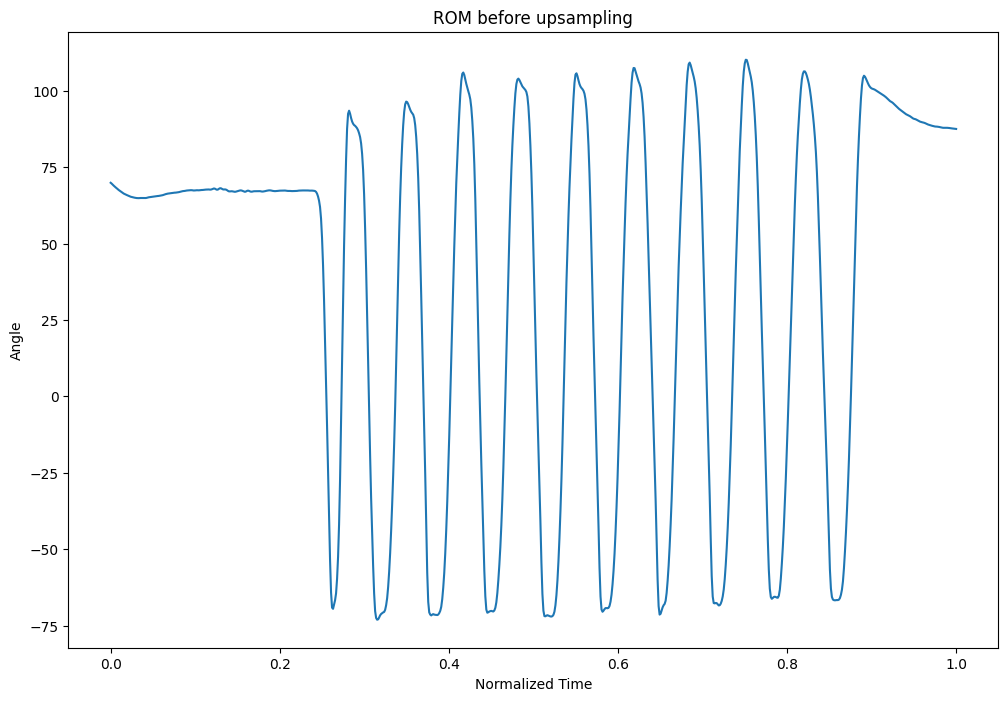

In [11]:
n = df_copy['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].notna().sum()
df_copy['tiempo_normalizado_rom'] = np.nan
non_na_indices = df_copy['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].dropna().index
df_copy.loc[non_na_indices, 'tiempo_normalizado_rom'] = np.linspace(0, 1, n)

col = 'angles_biceps_brachii_(right)_triceps_brachii_long_(right)'
plt.figure(figsize=(12, 8))
plt.plot(df_copy['tiempo_normalizado_rom'], df_copy[col], label=col)
plt.xlabel('Normalized Time')
plt.ylabel('Angle')
plt.title('ROM before upsampling')

In [12]:
min_angle = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].min()
max_angle = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].max()
print(f"Min. angle: {min_angle}")
print(f"Max. angle: {max_angle}")

Min. angle: -73.12387262393335
Max. angle: 110.26683410751131


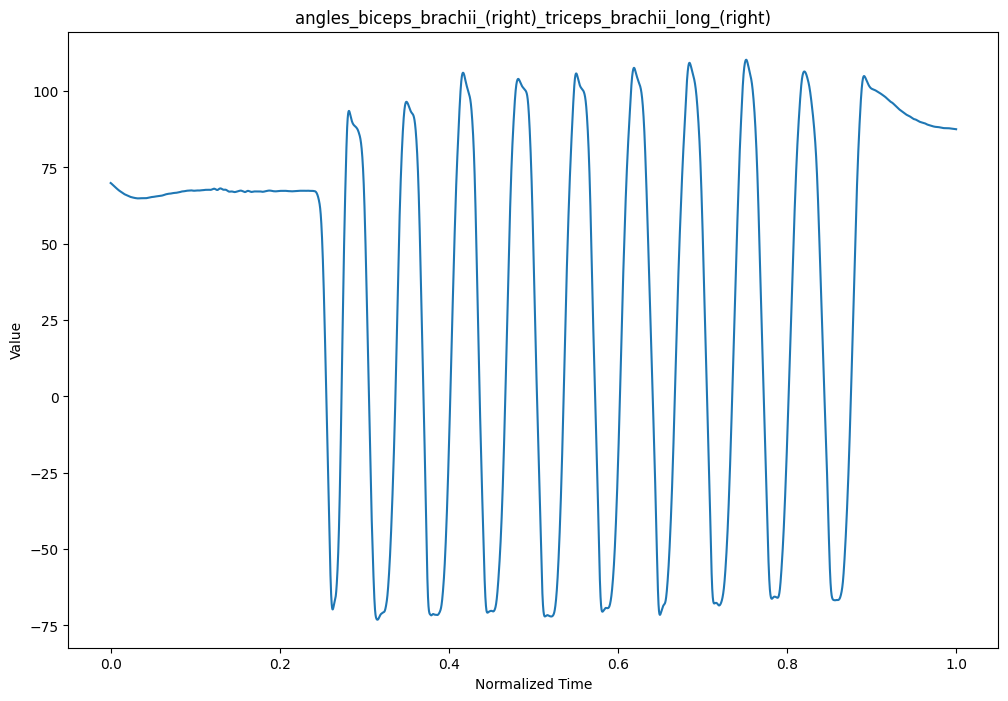

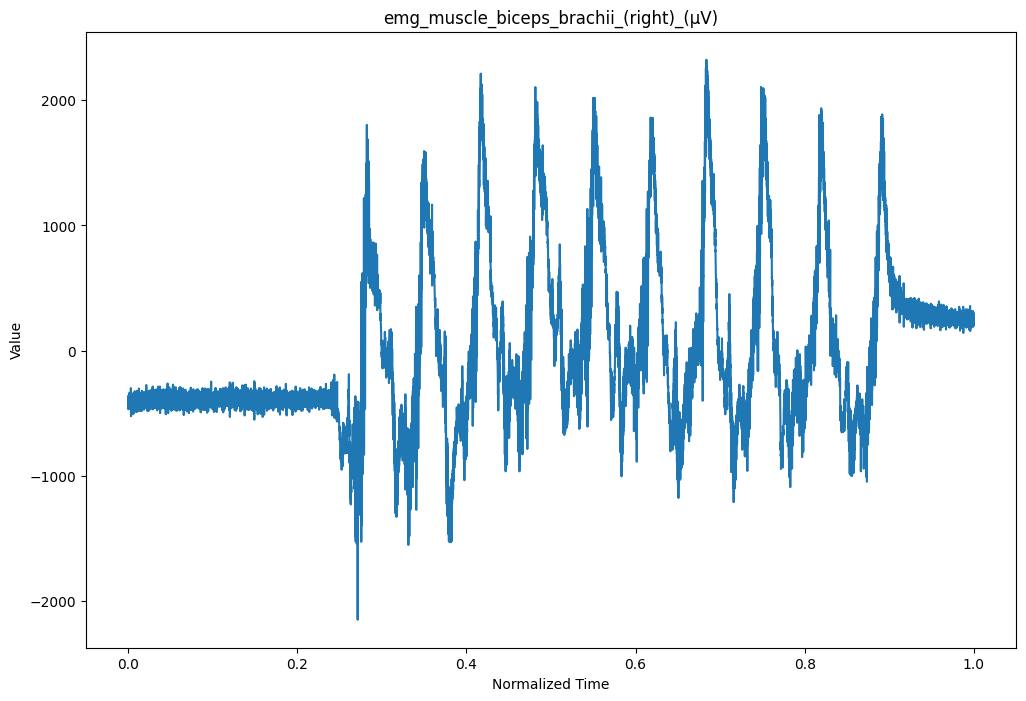

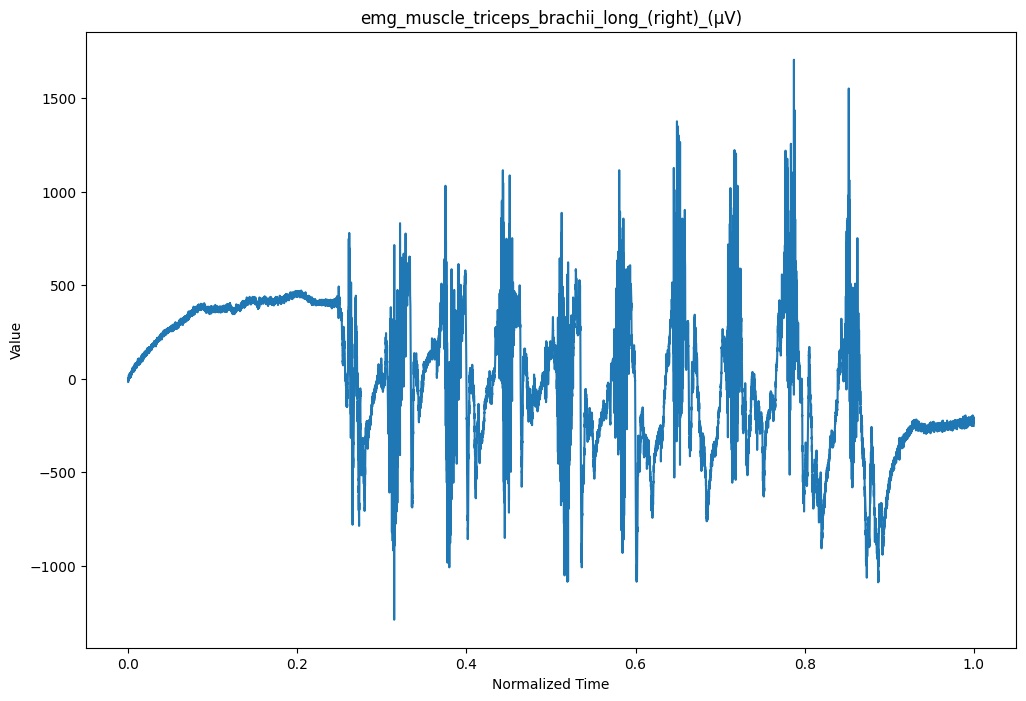

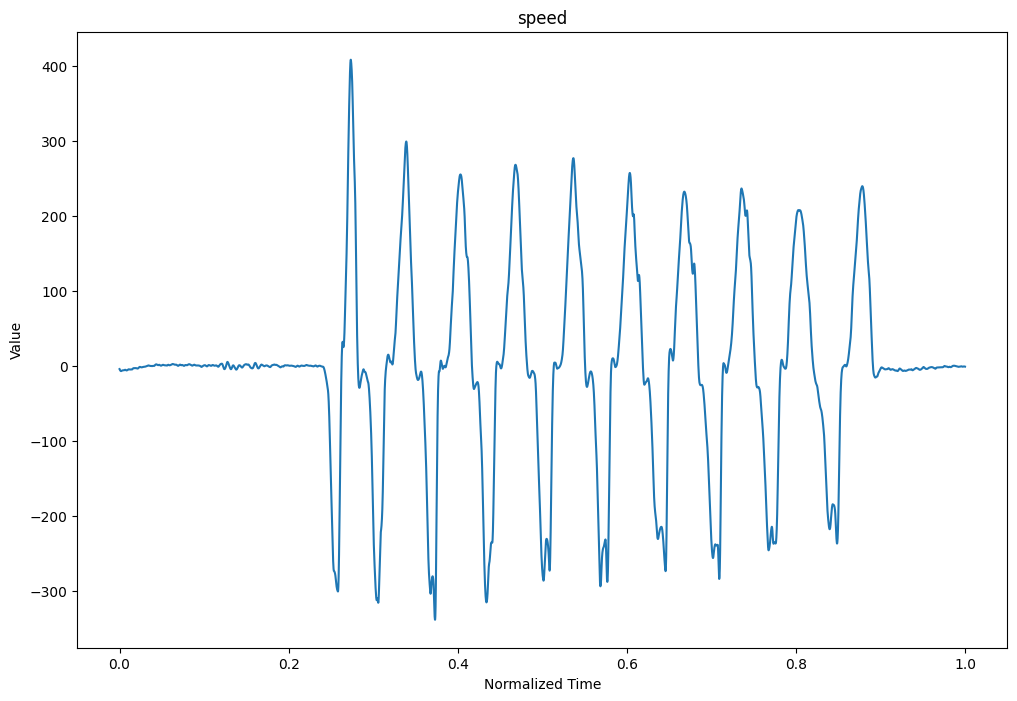

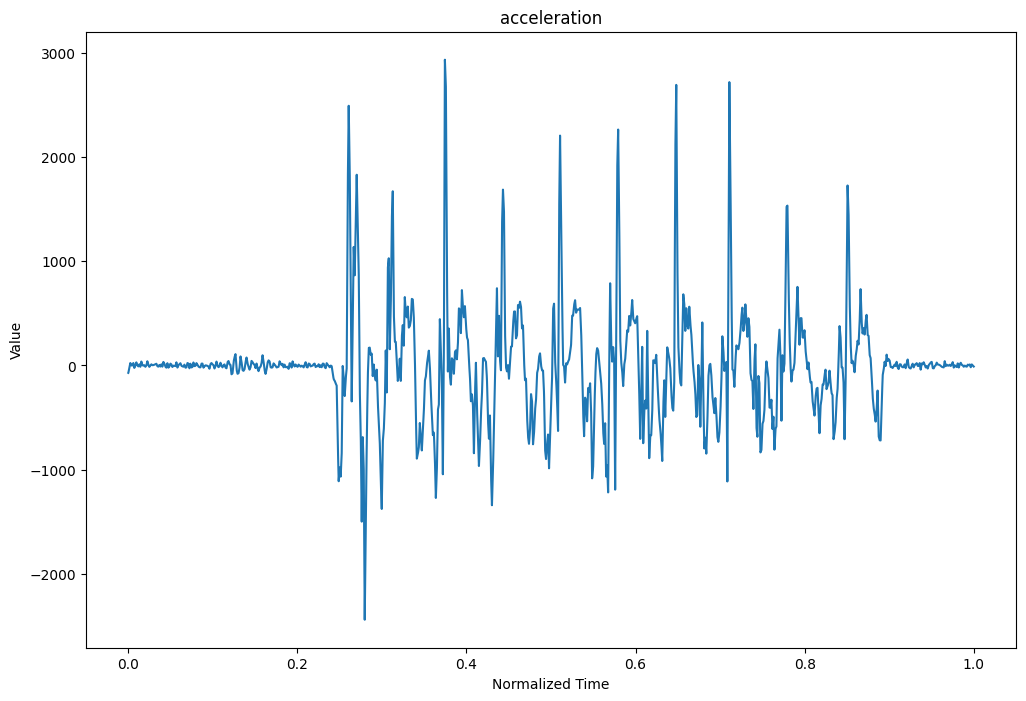

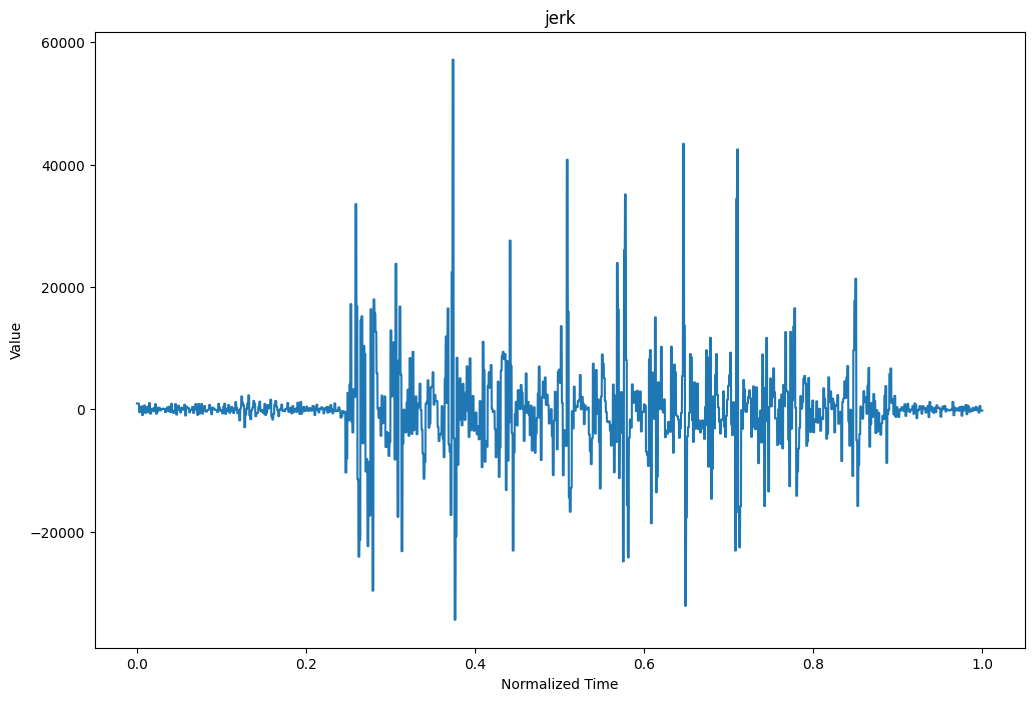

In [13]:
for col in df.columns:
    if col != 'tiempo_normalizado' and col != 'angles_window' and col != 'class' and col != 'BPM' and col != 'kid number':
        plt.figure(figsize=(12, 8))
        plt.plot(df['tiempo_normalizado'], df[col], label=col)
        plt.xlabel('Normalized Time')
        plt.ylabel('Value')
        plt.title(col)
        plt.show()
        plt.close()

In [14]:
df = borrar_y_renombrar(df)

In [15]:
df

,ROM,Biceps EMG,Triceps EMG,Speed,Acceleration,Jerk,Class,BPM,Kid number
0,69.890000,-464.723845,-18.156589,-4.230881,-70.877731,956.706539,2ESO,42,1
1,69.885766,-437.028845,-18.156589,-4.230881,-70.877731,956.706539,2ESO,42,1
2,69.881460,-403.178845,-15.079589,-4.301817,-70.877731,956.706539,2ESO,42,1
3,69.877085,-384.714845,-12.002589,-4.371796,-69.920231,956.706539,2ESO,42,1
4,69.872640,-387.791845,-8.924589,-4.440816,-68.962731,956.706454,2ESO,42,1
...,...,...,...,...,...,...,...,...,...
42210,87.513803,233.819155,-233.566589,-0.925873,-9.214263,-204.516321,2ESO,42,1
42211,87.512867,230.742155,-230.489589,-0.935300,-9.418949,-204.516420,2ESO,42,1
42212,87.511921,276.901155,-245.875589,-0.944932,-9.623635,-204.516363,2ESO,42,1
42213,87.510966,255.360155,-239.721589,-0.954768,-9.828320,-204.516392,2ESO,42,1


In [16]:
df.to_csv('advanced_mdurance-test-240835-5_modificado.csv', sep=';', index=False)